In [1]:
!pip install pytorch-fid

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pdb
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn.functional import binary_cross_entropy_with_logits as bce_loss
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.gridspec as gridspec
import math
import torchvision.transforms as T
from torchvision.utils import save_image
import os
from pytorch_fid.fid_score import calculate_fid_given_paths
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

In [3]:
train_dataset = datasets.MNIST(root = './MINST_dataset', train = True, transform = T.ToTensor(), download = True)
test_dataset = datasets.MNIST(root = './MINST_dataset', train = False, transform = T.ToTensor(), download = True)

transform = transforms.Resize((32, 32))

100%|██████████| 9912422/9912422 [00:00<00:00, 155393012.37it/s]


Extracting ./MINST_dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./MINST_dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24001524.44it/s]


Extracting ./MINST_dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./MINST_dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 50666984.60it/s]

Extracting ./MINST_dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MINST_dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21821911.53it/s]


Extracting ./MINST_dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MINST_dataset/MNIST/raw



In [4]:
train_dataset = [transform(image)*2-1 for image, label in train_dataset]
test_dataset = [transform(image)*2-1 for image, label in test_dataset]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
train_dataset = train_dataset[0:int(len(train_dataset)/4)]
test_dataset = test_dataset[0:int(len(test_dataset)/4)]

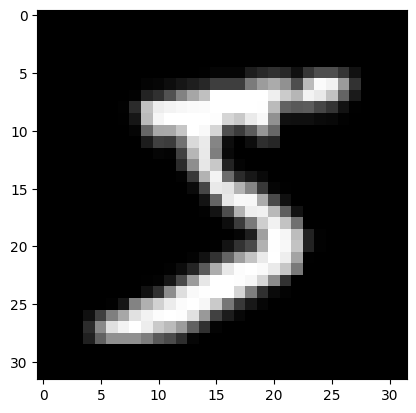

In [6]:
plt.imshow(train_dataset[0].numpy().reshape([32, 32]), cmap='gray')

In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 128, drop_last=True, shuffle = True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 128, drop_last=True, shuffle = True, pin_memory=True)

In [8]:
num = 0;
for real_data in train_loader:
      num = num +1
print(num)

117


In [9]:
class reshape(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.reshape(x.size(0), *self.shape)

class G_Residual(nn.Module):
  def __init__(self, in_channels, out_channels=256):
    super(G_Residual, self).__init__()
    self.Block1 = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
    )
    self.Block2 = nn.Upsample(scale_factor=2, mode='nearest')
  def forward(self, x):
    block1 = self.Block1(x)
    block2 = self.Block2(x)
    return block1 + block2

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(128, 256*4*4),
        reshape(256, 4, 4),
        nn.BatchNorm2d(256),
        G_Residual(256, 256),
        G_Residual(256, 256),
        G_Residual(256, 256),
        nn.ReLU(),
        nn.Conv2d(256, 1, kernel_size=3, stride=1, padding=1),
        nn.Tanh()
    )
  def forward(self, x):
    return self.model(x)

class D_Residual(nn.Module):
  def __init__(self, in_channels, out_channels, start=False, down_sampling=False):
    super(D_Residual, self).__init__()
    self.start = start
    self.down_sampling = down_sampling

    self.relu = nn.ReLU()
    self.Block1 = nn.Sequential(
        nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)),
        nn.ReLU(),
        nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)),
    )
    self.Block2 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    )
    self.avgpool2d = nn.AvgPool2d(kernel_size=2, stride=2, padding=1)
  def forward(self, x):
    if(self.start):
      block1 = self.relu(self.Block1(x))
    else:
      block1 = self.Block1(self.relu(x))
    if(self.down_sampling):
      block1 = self.avgpool2d(block1)
      x = self.avgpool2d(x)
    block2 = self.Block2(x)
    return block1 + block2

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        D_Residual(1, 128, start=True, down_sampling=True),
        D_Residual(128, 128, down_sampling=True),
        D_Residual(128, 128),
        D_Residual(128, 128),
        nn.ReLU()
    )
    self.FC1 = nn.Linear(128, 1)
    self.FC2 = nn.Linear(128, 4)
  def forward(self, x):
    x = self.model(x)
    x = torch.sum(x, dim=(2,3))
    realfake_logits = self.FC1(x)
    rotation_logits = self.FC2(x)
    return realfake_logits, rotation_logits

In [10]:
def sample_noise(batch_size, dim):
    return torch.rand(batch_size, dim, dtype = torch.float32) * 2 - 1

In [11]:
def discriminator_realfake_loss(logits_real, logits_fake):
  loss_pos = bce_loss(logits_real, torch.ones_like(logits_real))
  loss_neg = bce_loss(logits_fake, torch.zeros_like(logits_fake))
  loss = loss_pos + loss_neg
  return loss

def generator_realfake_loss(logits_fake):
  loss = bce_loss(logits_fake, torch.ones_like(logits_fake))
  return loss

def discriminator_rotation_loss(logits_real, logits_fake, batch_size, device):
  ce_loss = nn.CrossEntropyLoss()
  labels = torch.zeros(logits_real.shape[0])
  for i in range(batch_size):
    labels[i*4] = 0
    labels[i*4+1] = 1
    labels[i*4+2] = 2
    labels[i*4+3] = 3
  labels = labels.to(torch.long).to(device)
  loss = ce_loss(logits_real, labels) + ce_loss(logits_fake, labels)
  return loss

def generator_rotation_loss(logits_fake, batch_size, device):
  ce_loss = nn.CrossEntropyLoss()
  labels = torch.zeros(logits_fake.shape[0])
  for i in range(batch_size):
    labels[i*4] = 0
    labels[i*4+1] = 1
    labels[i*4+2] = 2
    labels[i*4+3] = 3
  labels = labels.to(torch.long).to(device)
  loss = ce_loss(logits_fake, labels)
  return loss

In [12]:
def get_optimizer(model):
  optimizer = optim.Adam(
      model.parameters(),
      lr=6e-6,
      betas=(0.9, 0.99)
  )
  return optimizer

In [13]:
def show_images(images):
  images = torch.reshape(images, [images.shape[0], -1])
  a = int(math.ceil(math.sqrt(images.shape[0])))
  b = int(math.ceil(math.sqrt(images.shape[1])))

  fig = plt.figure(figsize=(a/2, a/2))
  gs = gridspec.GridSpec(a, a)
  gs.update(wspace=0.05, hspace=0.05)

  for i, img in enumerate(images):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_aspect(1)
    plt.imshow(img.reshape([b,b]))
  return

In [14]:
def run(D, G, alpha, beta, D_opt, G_opt, D_realfake_loss, G_realfake_loss, D_rotation_loss, G_rotation_loss, batch_size = 128, num_epochs = 45):
  iter = 0
  D_losses = []
  G_losses = []

  device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
  D = D.to(device)
  G = G.to(device)
  for epoch in range(num_epochs):
    for real_data in train_loader:
      real_data = real_data.to(device)

      if(iter % 1 == 0):
        D_opt.zero_grad()
        noise = sample_noise(batch_size, 128).to(device)
        fake_images = G(noise).detach()

        x = fake_images
        x_90 = x.transpose(2,3)
        x_180 = x.flip(2,3)
        x_270 = x.transpose(2,3).flip(2,3)
        fake_images = torch.cat((x, x_90, x_180, x_270),0)

        x = real_data
        x_90 = x.transpose(2,3)
        x_180 = x.flip(2,3)
        x_270 = x.transpose(2,3).flip(2,3)
        real_data = torch.cat((x, x_90, x_180, x_270),0)

        D_realfake_fake_logits, D_fake_rotation_logits = D(fake_images)
        D_realfake_real_logits, D_real_rotation_logits = D(real_data)

        D_error = D_realfake_loss(D_realfake_real_logits, D_realfake_fake_logits) + beta*D_rotation_loss(D_fake_rotation_logits, D_real_rotation_logits, batch_size, device)
        D_error.backward()
        D_opt.step()

      if (iter % 1 == 0):
        G_opt.zero_grad()
        noise = sample_noise(batch_size, 128).to(device)
        fake_images = G(noise)

        x = fake_images
        x_90 = x.transpose(2,3)
        x_180 = x.flip(2,3)
        x_270 = x.transpose(2,3).flip(2,3)
        fake_images = torch.cat((x, x_90, x_180, x_270),0)

        G_realfake_fake_logits, G_rotation_fake_logits = D(fake_images)
        G_error = G_realfake_loss(G_realfake_fake_logits) + alpha*G_rotation_loss(G_rotation_fake_logits, batch_size, device)
        G_error.backward()
        G_opt.step()


      if (iter % 20 == 0):
        D_losses.append(D_error.item())
        G_losses.append(G_error.item())
        print(f'Discriminator Loss: {D_error.item()}\tGenerator Loss: {G_error.item()}')

      if (iter % 117 == 0):
        print('epoch:', int(iter/117))
        imgs_numpy = fake_images.data.cpu()
        show_images(imgs_numpy[0: 100])
        plt.show()
        print()
      iter += 1

  plt.plot(G_losses, label='Generator loss', alpha = 0.7)
  plt.plot(D_losses, label='Discriminator loss')
  plt.xlabel('Iteration / 20')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

Discriminator Loss: 10.453482627868652	Generator Loss: 1.3598341941833496
epoch: 0


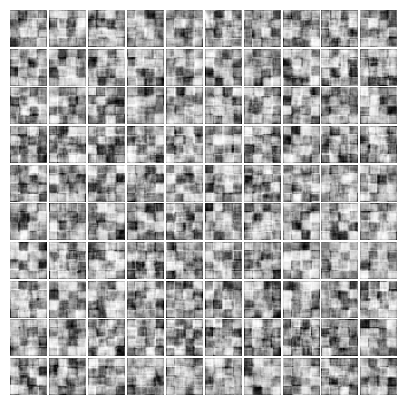


Discriminator Loss: 2.1579957008361816	Generator Loss: 1.5000429153442383
Discriminator Loss: 2.4880993366241455	Generator Loss: 1.113571286201477
Discriminator Loss: 1.9643135070800781	Generator Loss: 1.1792211532592773
Discriminator Loss: 1.5282995700836182	Generator Loss: 1.4987105131149292
Discriminator Loss: 1.2255486249923706	Generator Loss: 1.8557605743408203
epoch: 1


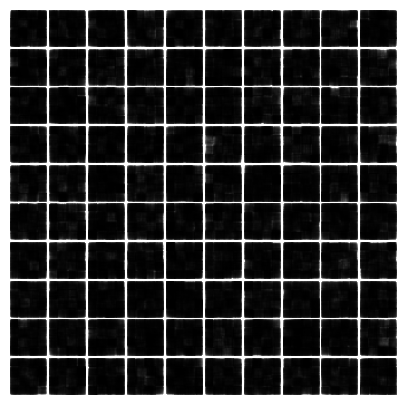


Discriminator Loss: 1.0972518920898438	Generator Loss: 2.2039058208465576
Discriminator Loss: 0.9926722049713135	Generator Loss: 2.339127540588379
Discriminator Loss: 3.5464935302734375	Generator Loss: 0.6975942850112915
Discriminator Loss: 0.835979163646698	Generator Loss: 3.576612949371338
Discriminator Loss: 2.0023036003112793	Generator Loss: 1.6393934488296509
Discriminator Loss: 1.507411241531372	Generator Loss: 1.508312463760376
epoch: 2


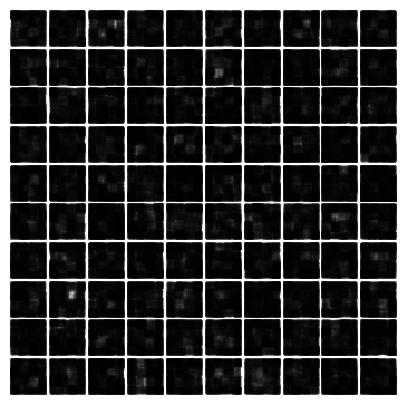


Discriminator Loss: 1.0914638042449951	Generator Loss: 2.322180986404419
Discriminator Loss: 0.9326359033584595	Generator Loss: 2.661548376083374
Discriminator Loss: 0.8650408983230591	Generator Loss: 2.928252935409546
Discriminator Loss: 0.8252984285354614	Generator Loss: 3.1972358226776123
Discriminator Loss: 0.7853858470916748	Generator Loss: 3.468935012817383
Discriminator Loss: 0.7722136378288269	Generator Loss: 3.672361135482788
epoch: 3


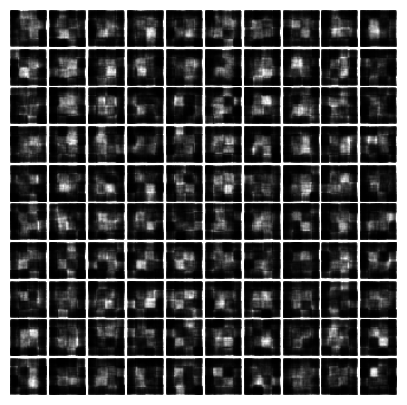


Discriminator Loss: 2.369830369949341	Generator Loss: 1.4455355405807495
Discriminator Loss: 0.815621018409729	Generator Loss: 3.504398822784424
Discriminator Loss: 1.4806987047195435	Generator Loss: 1.7892043590545654
Discriminator Loss: 1.2242839336395264	Generator Loss: 1.9643144607543945
Discriminator Loss: 0.9377706050872803	Generator Loss: 2.8236899375915527
Discriminator Loss: 1.6875050067901611	Generator Loss: 2.022972822189331
epoch: 4


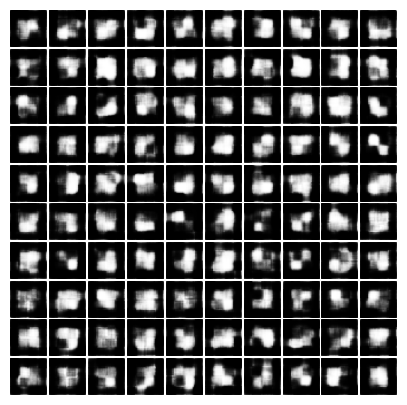


Discriminator Loss: 1.1572167873382568	Generator Loss: 1.9352326393127441
Discriminator Loss: 1.2880278825759888	Generator Loss: 2.134521484375
Discriminator Loss: 1.3484702110290527	Generator Loss: 1.8592880964279175
Discriminator Loss: 1.2028335332870483	Generator Loss: 2.3062939643859863
Discriminator Loss: 1.1726471185684204	Generator Loss: 1.9480805397033691
Discriminator Loss: 1.1159523725509644	Generator Loss: 2.5198631286621094
epoch: 5


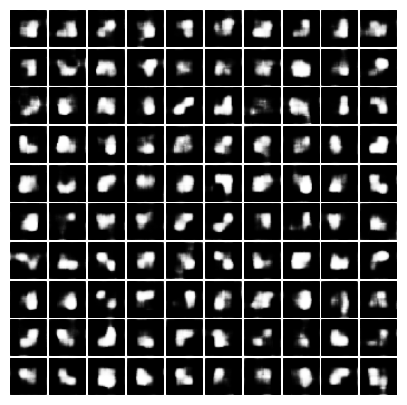


Discriminator Loss: 1.089629054069519	Generator Loss: 2.2945663928985596
Discriminator Loss: 1.0952093601226807	Generator Loss: 2.651986837387085
Discriminator Loss: 0.9956308007240295	Generator Loss: 2.355393409729004
Discriminator Loss: 1.0986875295639038	Generator Loss: 2.3810019493103027
Discriminator Loss: 1.0722852945327759	Generator Loss: 2.6127185821533203
Discriminator Loss: 1.1468881368637085	Generator Loss: 2.908048629760742
epoch: 6


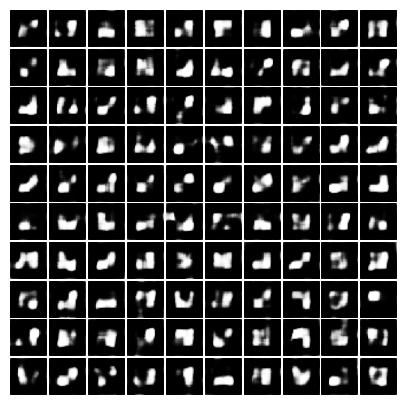


Discriminator Loss: 1.232140302658081	Generator Loss: 2.4601082801818848
Discriminator Loss: 1.5411487817764282	Generator Loss: 1.805665373802185
Discriminator Loss: 1.8483282327651978	Generator Loss: 1.968035101890564
Discriminator Loss: 1.9138319492340088	Generator Loss: 1.4861681461334229
Discriminator Loss: 1.9627957344055176	Generator Loss: 1.581353783607483
epoch: 7


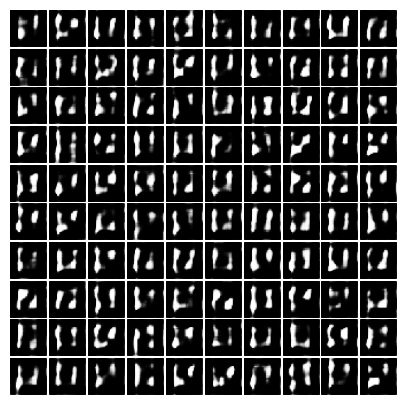


Discriminator Loss: 1.9066375494003296	Generator Loss: 1.3005905151367188
Discriminator Loss: 1.650167465209961	Generator Loss: 1.464158296585083
Discriminator Loss: 1.575196385383606	Generator Loss: 1.6596715450286865
Discriminator Loss: 1.9557888507843018	Generator Loss: 1.1968269348144531
Discriminator Loss: 1.1724722385406494	Generator Loss: 2.2620816230773926
Discriminator Loss: 1.8853839635849	Generator Loss: 1.3819186687469482
epoch: 8


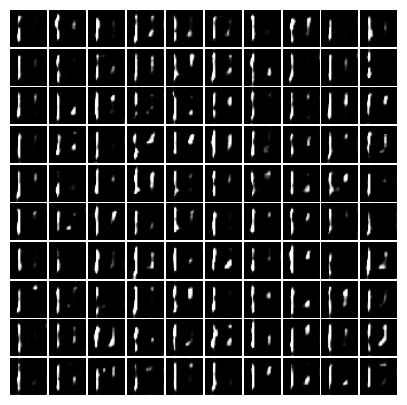


Discriminator Loss: 1.0023386478424072	Generator Loss: 2.5205135345458984
Discriminator Loss: 1.7297333478927612	Generator Loss: 1.5045548677444458
Discriminator Loss: 1.0116928815841675	Generator Loss: 2.5224997997283936
Discriminator Loss: 1.2536886930465698	Generator Loss: 2.2937216758728027
Discriminator Loss: 1.0280659198760986	Generator Loss: 2.3586792945861816
Discriminator Loss: 1.053661823272705	Generator Loss: 2.6066231727600098
epoch: 9


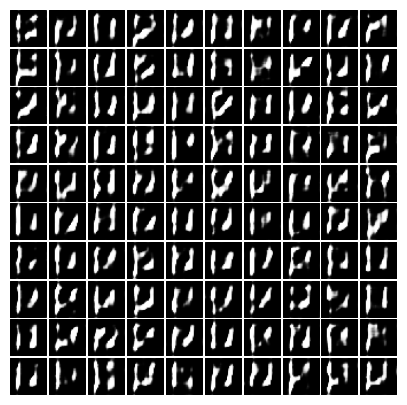


Discriminator Loss: 1.1832756996154785	Generator Loss: 2.492300271987915
Discriminator Loss: 1.1034870147705078	Generator Loss: 2.6349549293518066
Discriminator Loss: 1.1692161560058594	Generator Loss: 2.5665910243988037
Discriminator Loss: 1.258213758468628	Generator Loss: 2.625890016555786
Discriminator Loss: 1.1062021255493164	Generator Loss: 2.7471766471862793
Discriminator Loss: 1.2984602451324463	Generator Loss: 2.179321050643921
epoch: 10


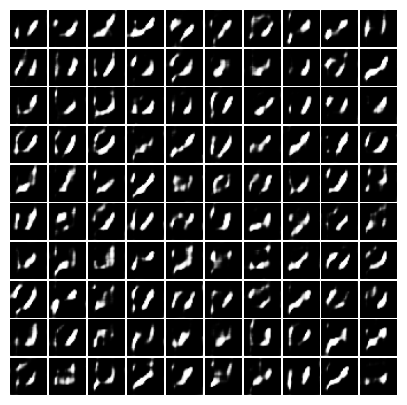


Discriminator Loss: 0.9757354855537415	Generator Loss: 2.4312708377838135
Discriminator Loss: 1.4203211069107056	Generator Loss: 1.8510855436325073
Discriminator Loss: 1.1651854515075684	Generator Loss: 2.6723742485046387
Discriminator Loss: 1.8084075450897217	Generator Loss: 1.8384742736816406
Discriminator Loss: 1.3931562900543213	Generator Loss: 2.829338312149048
Discriminator Loss: 1.6222478151321411	Generator Loss: 1.8007094860076904
epoch: 11


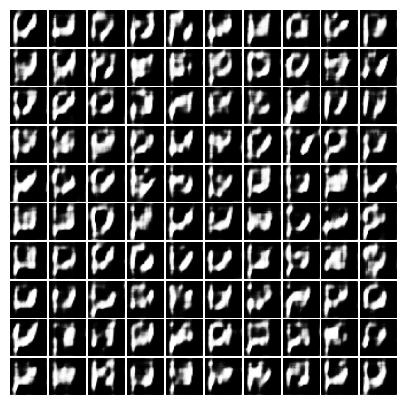


Discriminator Loss: 1.549979329109192	Generator Loss: 2.275355339050293
Discriminator Loss: 1.5424202680587769	Generator Loss: 1.841699481010437
Discriminator Loss: 1.865757942199707	Generator Loss: 1.372840166091919
Discriminator Loss: 1.4149900674819946	Generator Loss: 1.655170202255249
Discriminator Loss: 1.758073091506958	Generator Loss: 1.5140892267227173
Discriminator Loss: 1.2983779907226562	Generator Loss: 2.137817621231079
epoch: 12


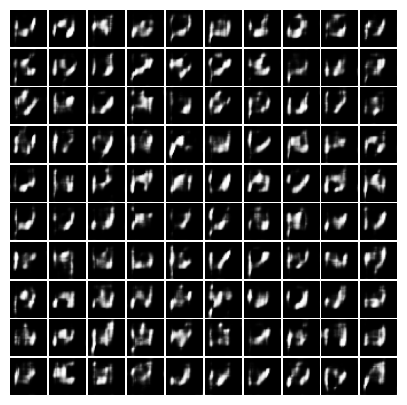


Discriminator Loss: 1.6098270416259766	Generator Loss: 1.6125264167785645
Discriminator Loss: 1.3672406673431396	Generator Loss: 1.7179415225982666
Discriminator Loss: 1.5450141429901123	Generator Loss: 1.5097886323928833
Discriminator Loss: 1.5587184429168701	Generator Loss: 1.7030980587005615
Discriminator Loss: 1.4279558658599854	Generator Loss: 1.816627025604248
Discriminator Loss: 1.5760772228240967	Generator Loss: 1.5895943641662598
epoch: 13


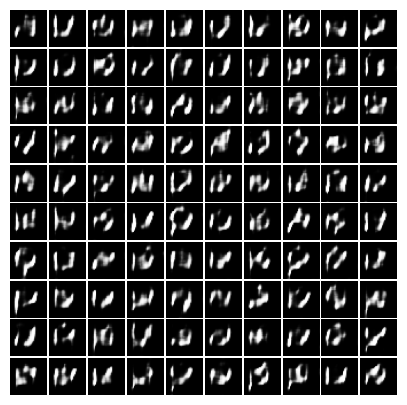


Discriminator Loss: 1.4871158599853516	Generator Loss: 1.7246360778808594
Discriminator Loss: 1.471238136291504	Generator Loss: 1.6882909536361694
Discriminator Loss: 1.77406907081604	Generator Loss: 1.510920524597168
Discriminator Loss: 1.4286549091339111	Generator Loss: 1.7279201745986938
Discriminator Loss: 1.510879397392273	Generator Loss: 2.1327226161956787
epoch: 14


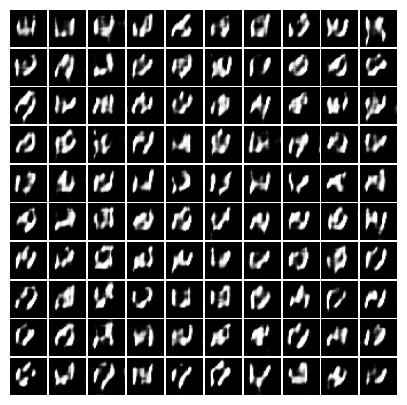


Discriminator Loss: 1.63534414768219	Generator Loss: 1.822704553604126
Discriminator Loss: 1.4581775665283203	Generator Loss: 2.070852518081665
Discriminator Loss: 1.820784568786621	Generator Loss: 1.3960148096084595
Discriminator Loss: 1.4841184616088867	Generator Loss: 2.056387424468994
Discriminator Loss: 1.551407814025879	Generator Loss: 1.6329902410507202
Discriminator Loss: 1.8349707126617432	Generator Loss: 1.471518874168396
epoch: 15


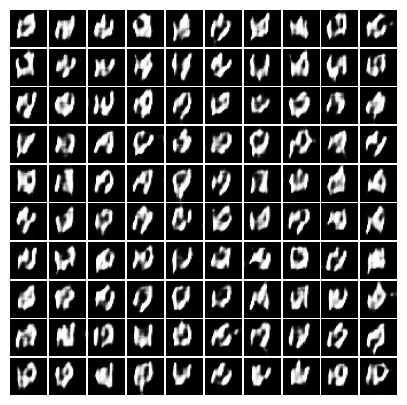


Discriminator Loss: 1.3358114957809448	Generator Loss: 1.645322561264038
Discriminator Loss: 1.8271484375	Generator Loss: 1.2585757970809937
Discriminator Loss: 1.6124625205993652	Generator Loss: 1.5885517597198486
Discriminator Loss: 1.8247814178466797	Generator Loss: 1.2641894817352295
Discriminator Loss: 1.6938756704330444	Generator Loss: 1.4651681184768677
Discriminator Loss: 1.6013270616531372	Generator Loss: 1.3229176998138428
epoch: 16


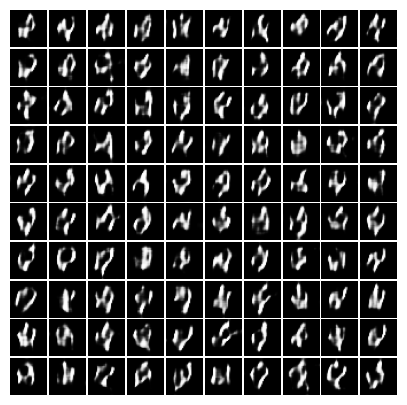


Discriminator Loss: 2.0243377685546875	Generator Loss: 1.3556976318359375
Discriminator Loss: 1.5675580501556396	Generator Loss: 1.4109386205673218
Discriminator Loss: 2.0890955924987793	Generator Loss: 1.0386154651641846
Discriminator Loss: 1.6619060039520264	Generator Loss: 1.575793743133545
Discriminator Loss: 2.041585922241211	Generator Loss: 1.3092491626739502
Discriminator Loss: 1.6125969886779785	Generator Loss: 1.6662442684173584
epoch: 17


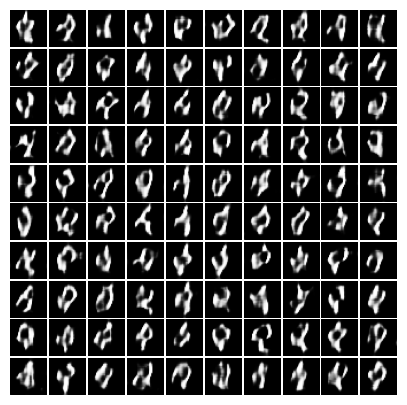


Discriminator Loss: 1.9249188899993896	Generator Loss: 1.4655896425247192
Discriminator Loss: 1.864142656326294	Generator Loss: 1.2792367935180664
Discriminator Loss: 1.6764991283416748	Generator Loss: 1.2857003211975098
Discriminator Loss: 1.8258838653564453	Generator Loss: 1.699375033378601
Discriminator Loss: 1.6284162998199463	Generator Loss: 1.5190576314926147
Discriminator Loss: 2.199615716934204	Generator Loss: 1.2217546701431274
epoch: 18


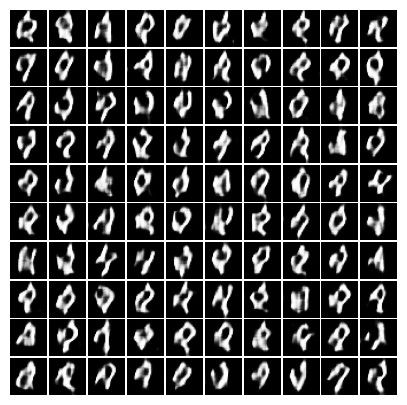


Discriminator Loss: 1.4883198738098145	Generator Loss: 1.6386394500732422
Discriminator Loss: 2.1254239082336426	Generator Loss: 1.3456844091415405
Discriminator Loss: 1.5818229913711548	Generator Loss: 1.613666296005249
Discriminator Loss: 2.1061625480651855	Generator Loss: 1.2835633754730225
Discriminator Loss: 1.5383248329162598	Generator Loss: 1.4587681293487549
Discriminator Loss: 2.2484006881713867	Generator Loss: 1.2676544189453125
epoch: 19


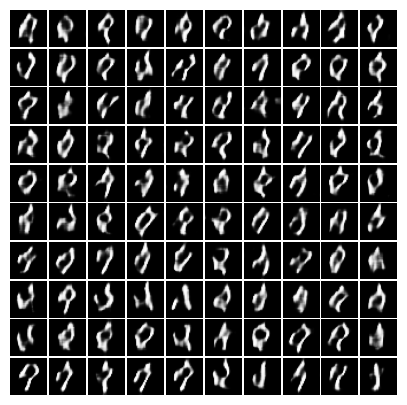


Discriminator Loss: 1.5429115295410156	Generator Loss: 1.4480767250061035
Discriminator Loss: 2.0143139362335205	Generator Loss: 1.1503986120224
Discriminator Loss: 1.4850819110870361	Generator Loss: 1.5708649158477783
Discriminator Loss: 2.1352744102478027	Generator Loss: 1.084639549255371
Discriminator Loss: 1.5382024049758911	Generator Loss: 1.542303204536438
Discriminator Loss: 2.045222520828247	Generator Loss: 1.4080992937088013
epoch: 20


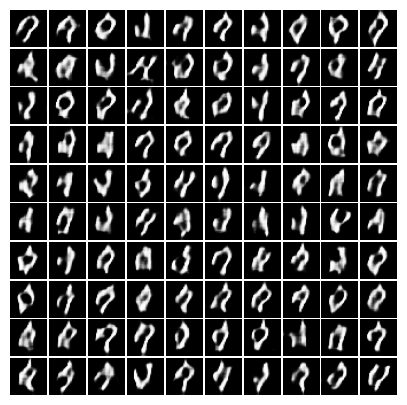


Discriminator Loss: 1.556240200996399	Generator Loss: 1.4207141399383545
Discriminator Loss: 2.0817105770111084	Generator Loss: 1.3399384021759033
Discriminator Loss: 1.6108982563018799	Generator Loss: 1.9174846410751343
Discriminator Loss: 1.8926432132720947	Generator Loss: 1.3676594495773315
Discriminator Loss: 1.6806243658065796	Generator Loss: 1.4326897859573364
epoch: 21


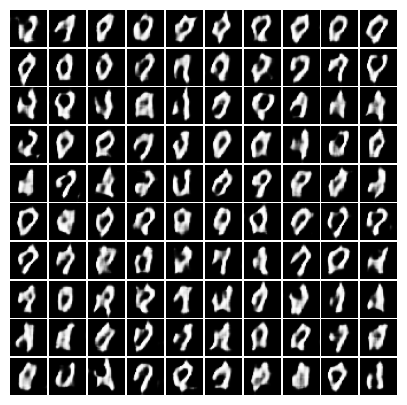


Discriminator Loss: 1.6575063467025757	Generator Loss: 1.7135227918624878
Discriminator Loss: 1.9784728288650513	Generator Loss: 1.1169040203094482
Discriminator Loss: 1.5956922769546509	Generator Loss: 1.650181531906128
Discriminator Loss: 2.036771774291992	Generator Loss: 1.2861003875732422
Discriminator Loss: 1.4880211353302002	Generator Loss: 1.480147361755371
Discriminator Loss: 2.066437244415283	Generator Loss: 1.374699592590332
epoch: 22


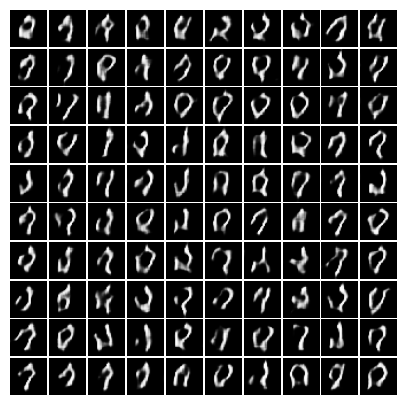


Discriminator Loss: 1.6446819305419922	Generator Loss: 1.372158408164978
Discriminator Loss: 2.092792272567749	Generator Loss: 1.2833603620529175
Discriminator Loss: 1.6015287637710571	Generator Loss: 1.2774229049682617
Discriminator Loss: 1.7705094814300537	Generator Loss: 1.5423400402069092
Discriminator Loss: 1.7140737771987915	Generator Loss: 1.1701834201812744
Discriminator Loss: 1.8431552648544312	Generator Loss: 1.6014611721038818
epoch: 23


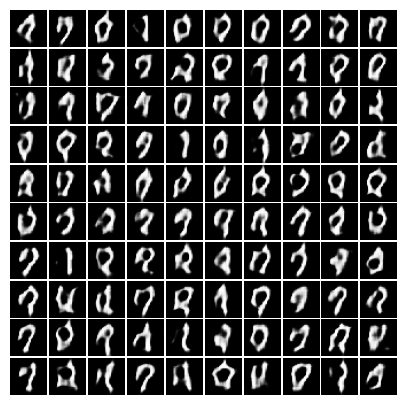


Discriminator Loss: 1.8258299827575684	Generator Loss: 1.3502310514450073
Discriminator Loss: 1.7453014850616455	Generator Loss: 1.3517897129058838
Discriminator Loss: 1.934349775314331	Generator Loss: 1.2498209476470947
Discriminator Loss: 1.8198847770690918	Generator Loss: 1.480663776397705
Discriminator Loss: 1.840017557144165	Generator Loss: 1.1944732666015625
Discriminator Loss: 1.5957633256912231	Generator Loss: 1.4972760677337646
epoch: 24


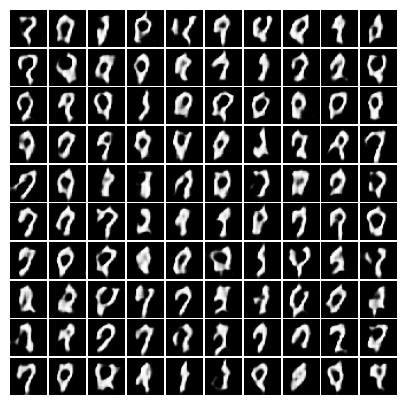


Discriminator Loss: 1.9177848100662231	Generator Loss: 1.3831883668899536
Discriminator Loss: 1.6449954509735107	Generator Loss: 1.738897681236267
Discriminator Loss: 1.8406133651733398	Generator Loss: 1.0221220254898071
Discriminator Loss: 1.5748904943466187	Generator Loss: 1.6838563680648804
Discriminator Loss: 1.9277660846710205	Generator Loss: 1.269269347190857
Discriminator Loss: 1.6056504249572754	Generator Loss: 1.496267318725586
epoch: 25


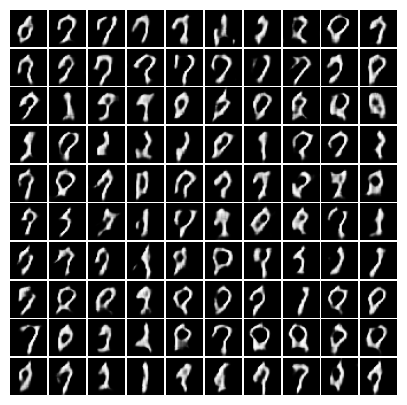


Discriminator Loss: 2.0813605785369873	Generator Loss: 0.9700583219528198
Discriminator Loss: 1.5536997318267822	Generator Loss: 1.6973083019256592
Discriminator Loss: 1.900763988494873	Generator Loss: 1.4741979837417603
Discriminator Loss: 1.767286777496338	Generator Loss: 1.3359253406524658
Discriminator Loss: 2.023242712020874	Generator Loss: 1.2172993421554565
Discriminator Loss: 1.7020150423049927	Generator Loss: 1.3715832233428955
epoch: 26


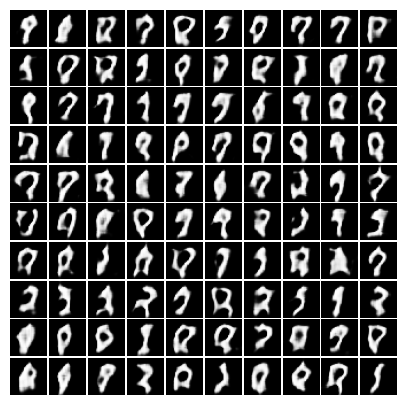


Discriminator Loss: 1.8247616291046143	Generator Loss: 1.511215329170227
Discriminator Loss: 1.7100412845611572	Generator Loss: 1.327147126197815
Discriminator Loss: 1.8300529718399048	Generator Loss: 1.8179932832717896
Discriminator Loss: 1.746767520904541	Generator Loss: 1.088753581047058
Discriminator Loss: 1.6507880687713623	Generator Loss: 1.5778967142105103
epoch: 27


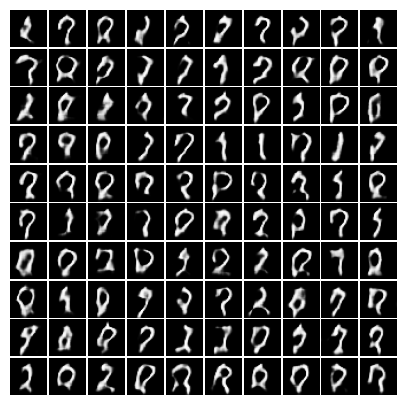


Discriminator Loss: 1.9055298566818237	Generator Loss: 1.2384033203125
Discriminator Loss: 1.6508610248565674	Generator Loss: 1.4744830131530762
Discriminator Loss: 1.8233702182769775	Generator Loss: 1.3191760778427124
Discriminator Loss: 1.7393105030059814	Generator Loss: 1.1533048152923584
Discriminator Loss: 1.8922126293182373	Generator Loss: 1.161298394203186
Discriminator Loss: 1.711084008216858	Generator Loss: 1.7038071155548096
epoch: 28


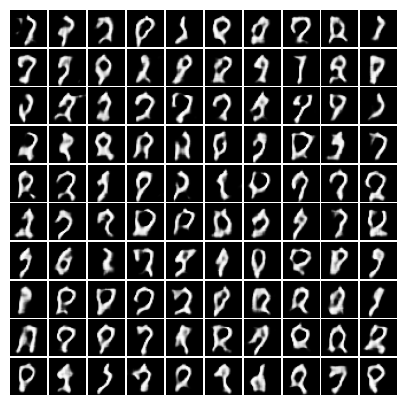


Discriminator Loss: 1.9218000173568726	Generator Loss: 1.4994876384735107
Discriminator Loss: 1.6763322353363037	Generator Loss: 1.4788830280303955
Discriminator Loss: 1.8744146823883057	Generator Loss: 1.220335841178894
Discriminator Loss: 1.6866118907928467	Generator Loss: 1.5707097053527832
Discriminator Loss: 1.8584481477737427	Generator Loss: 1.3991408348083496
Discriminator Loss: 1.7262487411499023	Generator Loss: 1.4620860815048218
epoch: 29


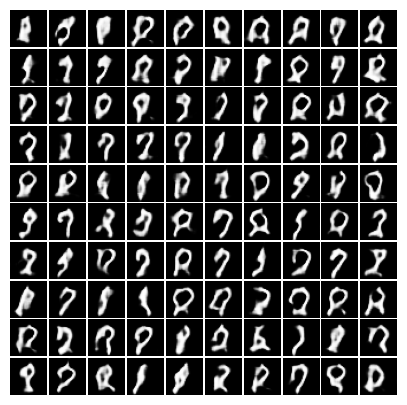


Discriminator Loss: 1.8978698253631592	Generator Loss: 1.2882113456726074
Discriminator Loss: 1.730994701385498	Generator Loss: 1.3620020151138306
Discriminator Loss: 1.8299260139465332	Generator Loss: 1.1583821773529053
Discriminator Loss: 1.8404674530029297	Generator Loss: 1.5354490280151367
Discriminator Loss: 1.8443090915679932	Generator Loss: 1.486433744430542
Discriminator Loss: 1.8962512016296387	Generator Loss: 1.3179787397384644
epoch: 30


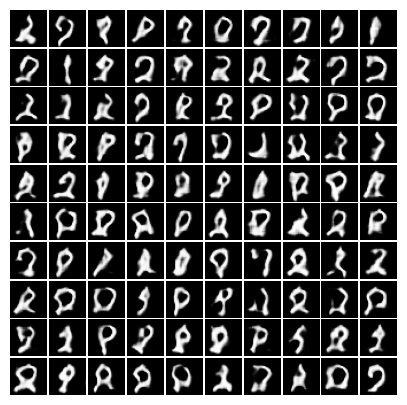


Discriminator Loss: 1.7451704740524292	Generator Loss: 1.4703195095062256
Discriminator Loss: 1.8446297645568848	Generator Loss: 1.564204454421997
Discriminator Loss: 1.7156978845596313	Generator Loss: 1.4157323837280273
Discriminator Loss: 1.807916283607483	Generator Loss: 1.2878540754318237
Discriminator Loss: 1.8652033805847168	Generator Loss: 1.1708145141601562
Discriminator Loss: 1.7134822607040405	Generator Loss: 1.4387683868408203
epoch: 31


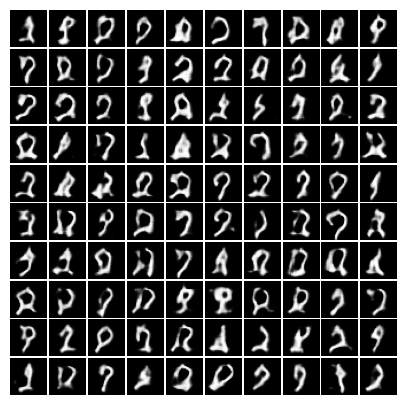


Discriminator Loss: 1.9483431577682495	Generator Loss: 1.1747257709503174
Discriminator Loss: 1.849900722503662	Generator Loss: 1.5297349691390991
Discriminator Loss: 1.8077934980392456	Generator Loss: 1.2964277267456055
Discriminator Loss: 1.86274254322052	Generator Loss: 0.9913517236709595
Discriminator Loss: 1.825758934020996	Generator Loss: 1.3380380868911743
Discriminator Loss: 1.9545611143112183	Generator Loss: 1.2607276439666748
epoch: 32


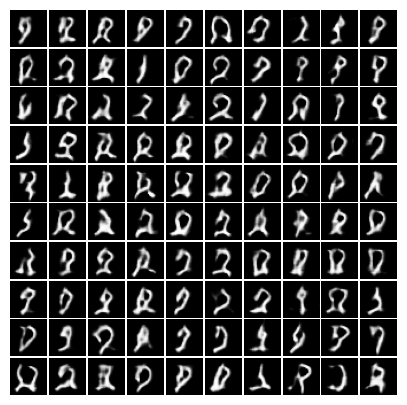


Discriminator Loss: 1.8629579544067383	Generator Loss: 1.518273115158081
Discriminator Loss: 1.8063756227493286	Generator Loss: 1.592128872871399
Discriminator Loss: 1.9384751319885254	Generator Loss: 1.3497936725616455
Discriminator Loss: 1.7540940046310425	Generator Loss: 1.4698272943496704
Discriminator Loss: 1.924946904182434	Generator Loss: 1.2177972793579102
Discriminator Loss: 1.8577224016189575	Generator Loss: 1.2117860317230225
epoch: 33


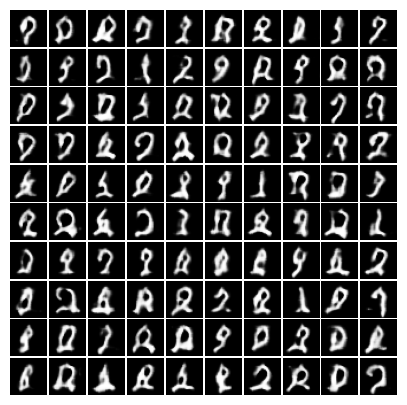


Discriminator Loss: 1.8368885517120361	Generator Loss: 1.3114776611328125
Discriminator Loss: 1.8821794986724854	Generator Loss: 1.2426191568374634
Discriminator Loss: 1.8940463066101074	Generator Loss: 1.4905062913894653
Discriminator Loss: 1.8369202613830566	Generator Loss: 1.1196672916412354
Discriminator Loss: 1.9102118015289307	Generator Loss: 1.299629807472229
epoch: 34


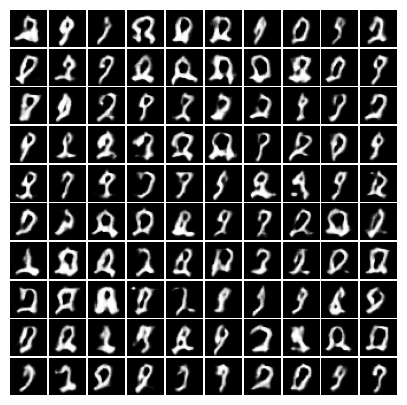


Discriminator Loss: 1.9023871421813965	Generator Loss: 1.1686575412750244
Discriminator Loss: 1.8474491834640503	Generator Loss: 1.1699162721633911
Discriminator Loss: 1.8436203002929688	Generator Loss: 1.2176607847213745
Discriminator Loss: 1.9014118909835815	Generator Loss: 1.1635843515396118
Discriminator Loss: 1.8670188188552856	Generator Loss: 1.1525237560272217
Discriminator Loss: 1.932187795639038	Generator Loss: 1.3545714616775513
epoch: 35


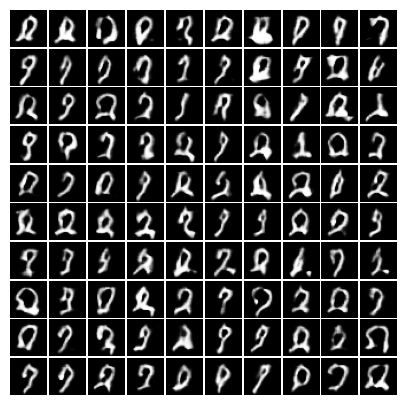


Discriminator Loss: 1.8732264041900635	Generator Loss: 1.195528268814087
Discriminator Loss: 1.8795334100723267	Generator Loss: 1.3795820474624634
Discriminator Loss: 1.8734948635101318	Generator Loss: 1.2226954698562622
Discriminator Loss: 1.8816605806350708	Generator Loss: 1.3437049388885498
Discriminator Loss: 1.8703761100769043	Generator Loss: 1.1952450275421143
Discriminator Loss: 1.8398752212524414	Generator Loss: 1.4886425733566284
epoch: 36


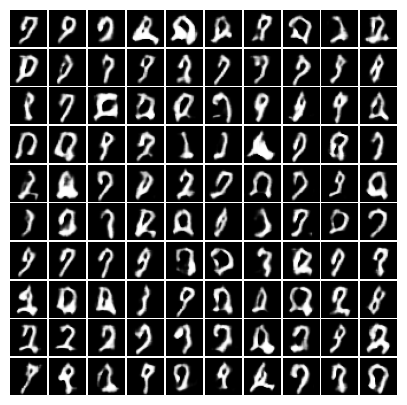


Discriminator Loss: 1.8939183950424194	Generator Loss: 1.2325561046600342
Discriminator Loss: 1.8986023664474487	Generator Loss: 1.3312530517578125
Discriminator Loss: 1.8742339611053467	Generator Loss: 1.0958940982818604
Discriminator Loss: 1.8691134452819824	Generator Loss: 1.1739360094070435
Discriminator Loss: 1.9651222229003906	Generator Loss: 1.2694675922393799
Discriminator Loss: 1.9447993040084839	Generator Loss: 1.3166346549987793
epoch: 37


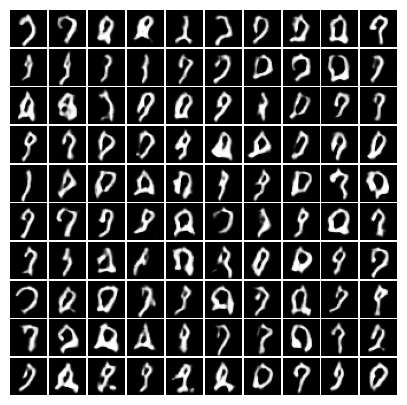


Discriminator Loss: 1.8692795038223267	Generator Loss: 1.0803464651107788
Discriminator Loss: 1.9437273740768433	Generator Loss: 1.1993604898452759
Discriminator Loss: 1.8932957649230957	Generator Loss: 1.2638423442840576
Discriminator Loss: 1.8661283254623413	Generator Loss: 1.1835895776748657
Discriminator Loss: 1.8266459703445435	Generator Loss: 1.3575350046157837
Discriminator Loss: 1.9712069034576416	Generator Loss: 1.0716707706451416
epoch: 38


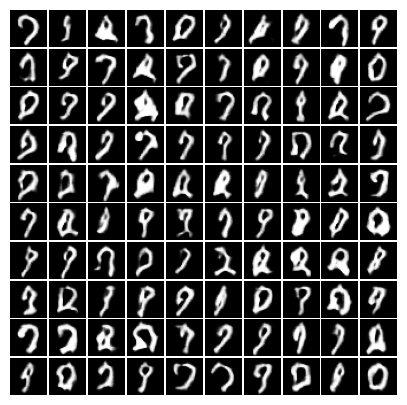


Discriminator Loss: 1.9654393196105957	Generator Loss: 1.21559476852417
Discriminator Loss: 1.9450525045394897	Generator Loss: 1.2296056747436523
Discriminator Loss: 1.9351074695587158	Generator Loss: 1.5625895261764526
Discriminator Loss: 1.9260004758834839	Generator Loss: 1.1207449436187744
Discriminator Loss: 2.043578863143921	Generator Loss: 0.9318342208862305
Discriminator Loss: 2.0020194053649902	Generator Loss: 1.2400975227355957
epoch: 39


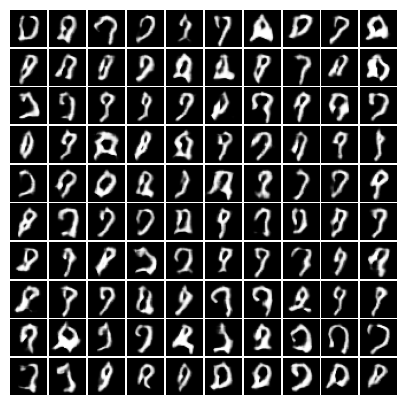


Discriminator Loss: 1.8879255056381226	Generator Loss: 1.1575989723205566
Discriminator Loss: 1.9192652702331543	Generator Loss: 1.2779580354690552
Discriminator Loss: 1.9696038961410522	Generator Loss: 1.1729736328125
Discriminator Loss: 1.9049749374389648	Generator Loss: 1.2422014474868774
Discriminator Loss: 1.9252970218658447	Generator Loss: 1.279414415359497
Discriminator Loss: 1.9296979904174805	Generator Loss: 1.222618579864502
epoch: 40


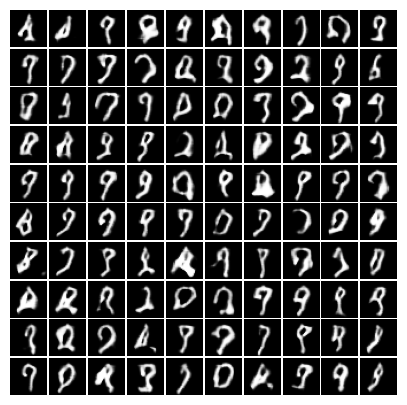


Discriminator Loss: 2.0074357986450195	Generator Loss: 1.2034651041030884
Discriminator Loss: 1.9015734195709229	Generator Loss: 1.2204865217208862
Discriminator Loss: 1.9582748413085938	Generator Loss: 1.209409236907959
Discriminator Loss: 1.975875735282898	Generator Loss: 1.3275582790374756
Discriminator Loss: 1.9129401445388794	Generator Loss: 1.0926108360290527
epoch: 41


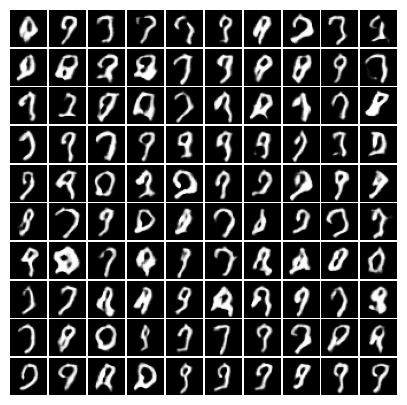


Discriminator Loss: 1.9631094932556152	Generator Loss: 1.046892523765564
Discriminator Loss: 1.9530041217803955	Generator Loss: 1.0979083776474
Discriminator Loss: 2.018467903137207	Generator Loss: 1.1011111736297607
Discriminator Loss: 1.9494104385375977	Generator Loss: 1.3908085823059082
Discriminator Loss: 1.9419680833816528	Generator Loss: 1.2601062059402466
Discriminator Loss: 1.9290821552276611	Generator Loss: 1.2948822975158691
epoch: 42


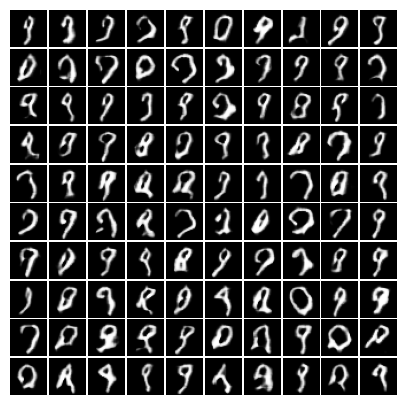


Discriminator Loss: 1.9532078504562378	Generator Loss: 1.2750720977783203
Discriminator Loss: 1.8759405612945557	Generator Loss: 1.2429808378219604
Discriminator Loss: 1.9746887683868408	Generator Loss: 0.9668010473251343
Discriminator Loss: 1.952481746673584	Generator Loss: 1.1593824625015259
Discriminator Loss: 1.9801156520843506	Generator Loss: 1.239166498184204
Discriminator Loss: 1.9222207069396973	Generator Loss: 1.3542354106903076
epoch: 43


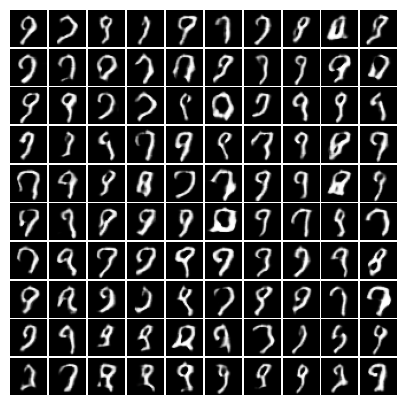


Discriminator Loss: 2.129136562347412	Generator Loss: 1.308531403541565
Discriminator Loss: 1.8931586742401123	Generator Loss: 1.4535279273986816
Discriminator Loss: 2.0315682888031006	Generator Loss: 1.1000275611877441
Discriminator Loss: 1.9438608884811401	Generator Loss: 1.2822036743164062
Discriminator Loss: 1.9344956874847412	Generator Loss: 1.2594901323318481
Discriminator Loss: 1.9454432725906372	Generator Loss: 1.2883259057998657
epoch: 44


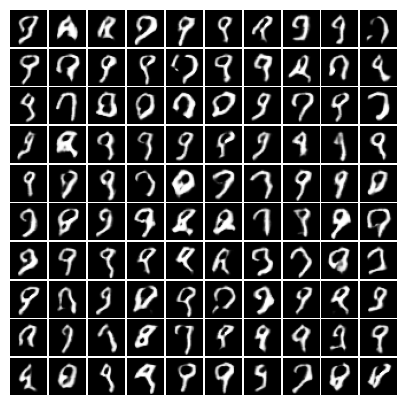


Discriminator Loss: 1.9739145040512085	Generator Loss: 1.39048171043396
Discriminator Loss: 1.9966151714324951	Generator Loss: 1.0328036546707153
Discriminator Loss: 1.9750511646270752	Generator Loss: 1.3037128448486328
Discriminator Loss: 1.9315643310546875	Generator Loss: 1.1443555355072021
Discriminator Loss: 1.959557294845581	Generator Loss: 1.2193806171417236
Discriminator Loss: 1.946626901626587	Generator Loss: 1.1256355047225952


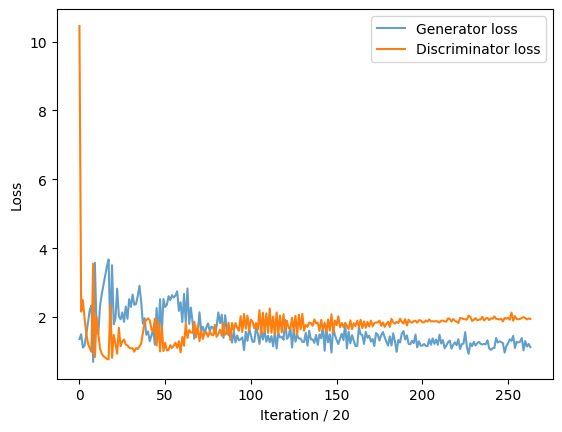

In [15]:
D = Discriminator()
G = Generator()
alpha = 0.25
beta = 0.25
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

run(D, G, alpha, beta, get_optimizer(D), get_optimizer(G), discriminator_realfake_loss, generator_realfake_loss, discriminator_rotation_loss, generator_rotation_loss)

In [16]:
test_data = test_loader.dataset.data.reshape(-1, 784).float()/127 - 1

AttributeError: 'list' object has no attribute 'data'

In [17]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
os.makedirs('./real_images', exist_ok=True)
for i, image in enumerate(test_dataset[0:500]):
    image = (image + 1) /2
    save_image(image.reshape(32, 32), os.path.join('./real_images', f"real_{i}.jpg"))

os.makedirs('./fake_images', exist_ok=True)
fake_images = G(torch.randn(500, 128).to(device))
for i, image in enumerate(fake_images):
    image = (image + 1) /2
    save_image(image.cpu().detach().reshape(32, 32), os.path.join('./fake_images', f"fake_{i}.jpg"))

In [22]:
use_cuda = torch.cuda.is_available()
fid_score = calculate_fid_given_paths(
    ['./real_images', './real_images'],
    batch_size=50,
    dims=2048,
    device = torch.device("cuda" if use_cuda else "cpu")
)
print(f'FID Score: {fid_score:.4f}')

100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


ValueError: Imaginary component 5.244091220662155e+58